In [3]:
import numpy as np
import camb
from numpy.fft import fftshift
from tqdm import tqdm
import time

import lensit as li
from lensit.clusterlens import lensingmap, profile
from lensit.misc.misc_utils import gauss_beam
from lensit.ffs_covs import ffs_cov, ell_mat


import os
import os.path as op
import matplotlib as mpl
from matplotlib import pyplot as plt
from lensit.pbs import pbs
from scipy.interpolate import UnivariateSpline as spline


In [64]:
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['font.size'] = 20
mpl.rcParams['figure.figsize'] = 8.5, 5.5

mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rc('text', usetex=True)
mpl.rcParams['errorbar.capsize'] = 4
mpl.rc('legend', fontsize=15)

In [5]:
# We start by intiating CAMB which will give us the relevant cosmology 
cambinifile = 'planck_2018_acc'

pars = camb.read_ini(op.join(op.dirname('/home/users/s/sahasay2/git_repos/camb/inifiles'),  'inifiles', cambinifile + '.ini'))
results = camb.get_results(pars)

In [14]:
# We define here the parameters for the profile of the cluster
M200, z = 2 * 1e14, 0.7
profname = 'nfw'
key = "lss" # "lss"/"cluster"/"lss_plus_cluster"
profparams={'M200c':M200, 'z':z}
hprofile = profile.profile(results, profname)
xmax = 3*hprofile.get_concentration(M200, z)
# Define here the map square patches
npix = 1024  # Number of pixels
lpix_amin = 0.3 # Physical size of a pixel in arcmin (There is bug when <0.2 amin, due to low precision in Cl_TE at )

print("The size of the data patch is %0.1f X %0.1f arcmin central box"%(npix*lpix_amin, npix*lpix_amin))

# Maximum multipole used to generate the CMB maps from the CMB power spectra
# ellmaxsky = 6000 # (bug when ellmax>6300 because of low precision in Cl_TE of CAMB )
ellmaxsky = 10000 

# Set the maximum ell observed in the CMB data maps
ellmaxdat = 5000
ellmindat = 100

# Number of simulated maps 
nsims = 1000

# Set CMB experiment for noise level and beam
cmb_exp='S4_sayan'

# We will cache things in this directory 
libdir = lensingmap.get_cluster_libdir(cambinifile,  profname, key, npix, lpix_amin, ellmaxsky, M200, z, nsims, cmb_exp)
print(libdir)

The size of the data patch is 307.2 X 307.2 arcmin central box
/home/users/s/sahasay2/lensit_sims/temp/clustermaps/camb_planck_2018_acc/cmbexp_S4_sayan/nfw_profile/lensed_by_lss/npix1024_lpix_0.3amin_lmaxsky10000/M200_2.000000E+14_z0.7/1000_sims


In [16]:
np.random.seed(seed=20)
clustermaps = lensingmap.cluster_maps(libdir, key, npix, lpix_amin, nsims, results, profparams, profilename=profname,  ellmax_sky = ellmaxsky, ellmax_data=ellmaxdat, ellmin_data=ellmindat, cmb_exp=cmb_exp)

In [15]:
lmax = ellmaxsky
cpp_fid = results.get_lens_potential_cls(lmax=lmax, raw_cl=True).T[0]

camb_cls = results.get_unlensed_scalar_cls(CMB_unit='muK', raw_cl=True, lmax=lmax).T
cls_unl_fid = {'tt':camb_cls[0], 'ee':camb_cls[1], 'bb':camb_cls[2], 'te':camb_cls[3], 'pp':cpp_fid}

camb_cls_len = results.get_lensed_scalar_cls(CMB_unit='muK', raw_cl=True, lmax=lmax).T
cls_len_fid = {'tt':camb_cls_len[0], 'ee':camb_cls_len[1], 'bb':camb_cls_len[2], 'te':camb_cls_len[3], 'pp':cpp_fid}

camb_cls_len = results.get_lensed_gradient_cls(CMB_unit='muK', raw_cl=True, lmax=lmax).T
cls_gradlen_fid = {'tt':camb_cls_len[0], 'ee':camb_cls_len[1], 'bb':camb_cls_len[2], 'te':camb_cls_len[4], 'pp':cpp_fid}

In [17]:
ellmax_sky = clustermaps.ellmax_sky
sN_uKamin, sN_uKaminP, Beam_FWHM_amin, ellmin, ellmax = li.get_config(clustermaps.cmb_exp)

cls_noise = {'t': (sN_uKamin * np.pi / 180. / 60.) ** 2 * np.ones(clustermaps.ellmax_sky + 1),
            'q':(sN_uKaminP * np.pi / 180. / 60.) ** 2 * np.ones(clustermaps.ellmax_sky + 1),
            'u':(sN_uKaminP * np.pi / 180. / 60.) ** 2 * np.ones(clustermaps.ellmax_sky + 1)}  # simple flat noise Cls
# cl_transf = gauss_beam(Beam_FWHM_amin / 60. * np.pi / 180., lmax=ellmax_sky)
# lib_alm = ell_mat.ffs_alm_pyFFTW(get_ellmat(LD_res, HD_res=HD_res),
                    # filt_func=lambda ell: (ell >= ellmin) & (ell <= ellmax), num_threads=pyFFTWthreads)
# lib_skyalm = ell_mat.ffs_alm_pyFFTW(clustermaps.ellmat,
                    # filt_func=lambda ell: (ell <= ellmax_sky), num_threads=clustermaps.num_threads)

cl_transf = clustermaps.cl_transf
lib_skyalm = clustermaps.lib_skyalm

typ = 'T'

lib_dir = op.join(clustermaps.dat_libdir, typ)
# isocov = ffs_cov.ffs_diagcov_alm(lib_dir, clustermaps.lib_datalm, clustermaps.cls_unl, cls_len, cl_transf, cls_noise, lib_skyalm=lib_skyalm)
isocov = ffs_cov.ffs_diagcov_alm(lib_dir, clustermaps.lib_datalm, cls_unl_fid, cls_len_fid, cl_transf, cls_noise, lib_skyalm=lib_skyalm)

In [105]:
# Load the normalisation files
wl_1 = np.loadtxt("normalisation_cstMF_lmax5k_lmin100_lmaxout10k_nit20_tot1em7_sims1k.dat")

In [86]:
wl_1[0]=0.0

In [106]:
wl_sm = np.zeros((len(wl_1)))

In [107]:
def smooth_array(arr, window_size=3):
    """
    Smooths an array by applying a moving average filter.
    
    Arguments:
    arr -- The input array to be smoothed.
    window_size -- The size of the moving window (default: 3).
    
    Returns:
    The smoothed array.
    """
    smoothed = []
    for i in range(len(arr)):
        start = max(0, i - window_size // 2)
        end = min(len(arr), i + window_size // 2 + 1)
        window = arr[start:end]
        average = sum(window) / len(window)
        smoothed.append(average)
    return smoothed

In [108]:
ell, = np.where(isocov.lib_skyalm.get_Nell()[:6000])
el = ell[1:]

In [109]:
# smooth the array
wl_smooth = smooth_array(wl_1[el], 10)

In [112]:
wl_sm[el] = wl_smooth

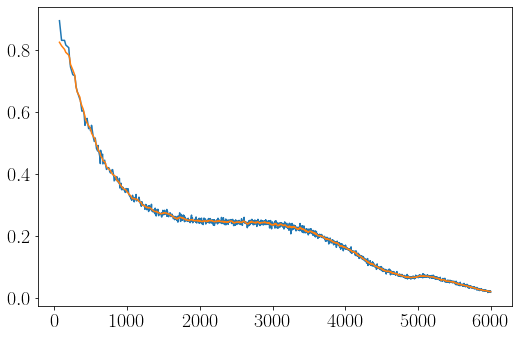

In [111]:
plt.plot(el, wl_1[el], label='original')
plt.plot(el, wl_sm[el], label='smoothed')

In [114]:
np.savetxt("normalisation_cstMF_lmax5k_lmin100_lmaxout6k_nit20_tot1em7_sims1k_smoothed.dat", wl_sm)

In [ ]:
wl_sm[ell]